In [11]:
# Introduction
# Notebook for generating lyrics using LSTM network. The dataset contains all the songs recorded by Bob Dylan. Stages:
# 
# EDA
# - Summary statistics on dataset: distribution of no. of characters, words, sentences in collection
# - Histograms & wordclouds
# 
# Preprocessing
# - Create corpus of all words from lyrics
# - Cleaning: remove special characters, convert to lowercase
# - Create mapping of unique chars to indices
# - Create features and targets (categorical)
# 
# Model
# - Train LSTM model, one character at a time
# - Visualize learning and loss
# 
# Generation
# - Generate lyrics from seed phrase, one character at a time, using model predictions

In [2]:
# Imports
# Core
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string, os, sys, warnings, random, io
warnings.filterwarnings("ignore")

# NLP
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
import nltk
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

In [3]:
# EDA

# Load song lyrics dataset
df_songs = pd.read_csv(r"C:\Users\S VARSHA\OneDrive\Desktop\azlyrics_lyrics_w.csv", on_bad_lines='skip')


In [4]:
df_songs = df_songs[['ARTIST_NAME', 'SONG_NAME', 'LYRICS']]


In [5]:
df_songs.head()

,ARTIST_NAME,SONG_NAME,LYRICS
0,wade bowen,in my soul,"i know you're a long ways away from me, i'm he..."
1,wade bowen,prove it to you,"people sit and ask me sometimes, what are you ..."
2,wade bowen,why can't you love me,"why can't you love me?, what can't you just be..."
3,wade bowen,walking shoes,"if you keep walking in circles, you're gonna f..."
4,world war me,the good enough,"i try to regain some sanity, well it's hard wh..."


In [6]:
import nltk
nltk.download('punkt')# to split text into words and sentences


[nltk_data] Downloading package punkt to C:\Users\S
[nltk_data]     VARSHA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
# Summary stats
df_songs["n_chars"] = df_songs["LYRICS"].apply(len)# Counts the number of characters (letters) in each song.
df_songs["n_words"] = df_songs.apply(lambda row: nltk.word_tokenize(row["LYRICS"]), axis=1).apply(len)#Counts the number of words in each song.
df_songs["n_lines"] = df_songs["LYRICS"].str.split('\n').apply(len)#Counts the number of lines in each song.
df_songs.describe()# Shows summary statistics for these counts (like average, min, and max).

,n_chars,n_words,n_lines
count,4229.000000,4229.000000,4229.0
mean,1309.137385,321.347127,1.0
std,784.595294,185.523905,0.0
min,25.000000,7.000000,1.0
25%,815.000000,200.000000,1.0
50%,1119.000000,278.000000,1.0
75%,1566.000000,392.000000,1.0
max,7437.000000,1715.000000,1.0


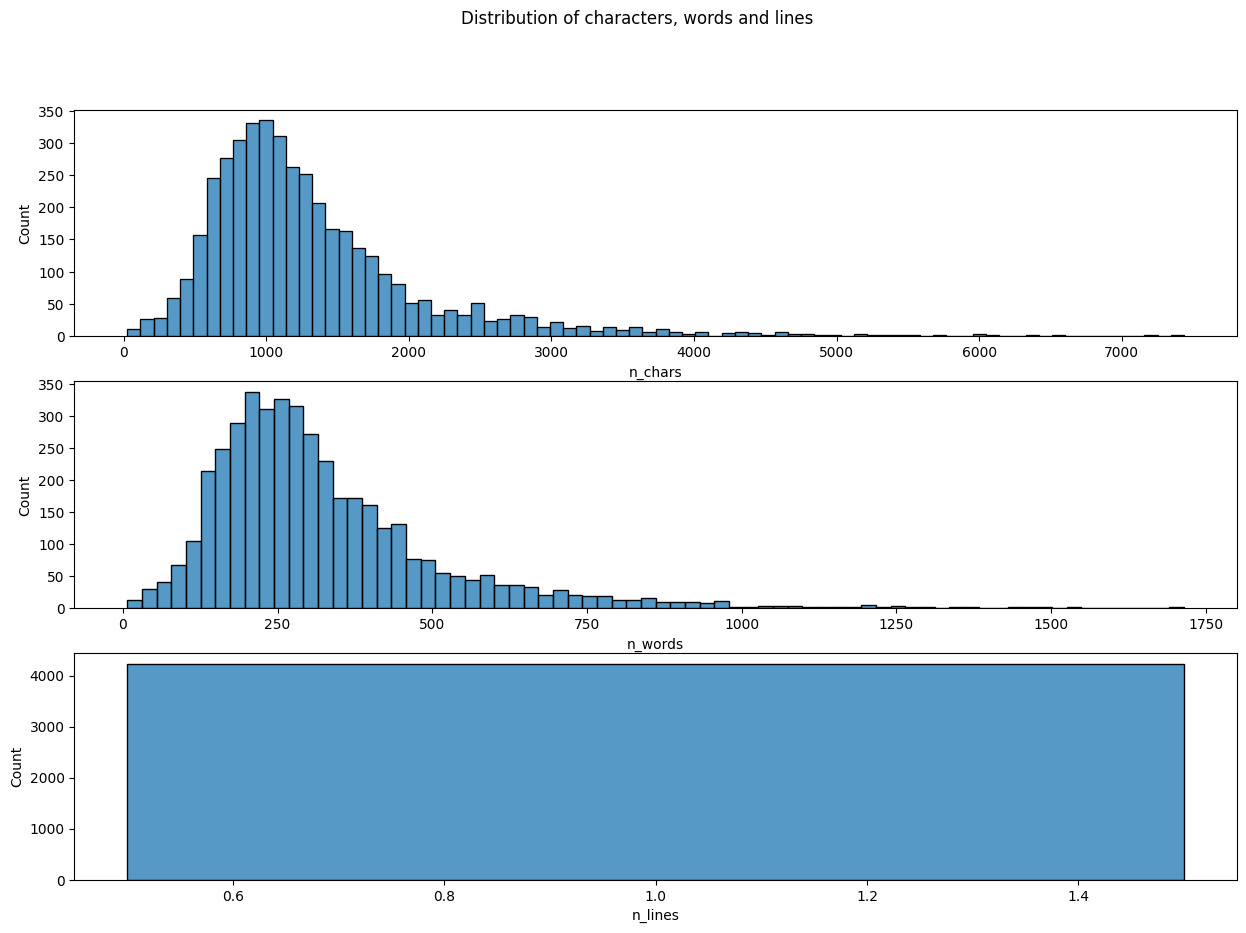

In [8]:
# Plot distribution of chars, words, sentences in lyrics
fig, axs = plt.subplots(3, 1, figsize=(15, 10))
fig.suptitle('Distribution of characters, words and lines')
sns.histplot(data=df_songs, x='n_chars', ax=axs[0])
sns.histplot(data=df_songs, x='n_words', ax=axs[1])
sns.histplot(data=df_songs, x='n_lines', ax=axs[2])
plt.show()

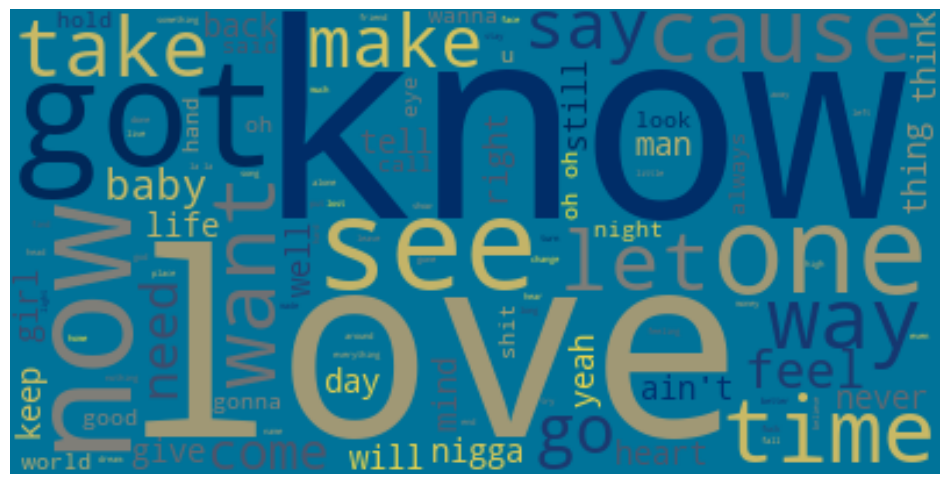

In [9]:
# Wordcloud
stopwords = set(STOPWORDS)
wc = WordCloud(stopwords=stopwords, background_color="#007399", colormap="cividis", max_words=100)
wc.generate(" ".join(df_songs.LYRICS))
plt.figure(figsize=(12,12))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

In [10]:
# Sample lyrics
song_idx = 100
print(df_songs.loc[song_idx, :])
df_songs.loc[song_idx, 'LYRICS'].split('\n')[:30]

ARTIST_NAME                                       wynette, tammy
SONG_NAME                               there goes my everything
LYRICS         i hear footsteps slowly walking as they gently...
n_chars                                                      471
n_words                                                       97
n_lines                                                        1
Name: 100, dtype: object


["i hear footsteps slowly walking as they gently walk across a lonely floor, and a voice that's softly saying darling this will be goodbye forever more, there goes my reason for living there goes the one of my dreams, there goes my only possesion there goes my everything, as my mem'ry turns back the pages i can see the happy years we had before, and the love that kept this cold heart beating, has been shattered by the closing of a door, there goes my reason for living."]

In [11]:
# Preprocessing
df_songs.shape

(4229, 6)

In [12]:
# Create corpus
corpus = ''
for text in df_songs.LYRICS:
    corpus += text
    
corpus = corpus.lower()
print("Number of unique characters:", len(set(corpus)))

Number of unique characters: 63


In [13]:
# Cleaning
special_chars = ['\x0b', '"', '(', ')', '`', '¥', '©', 'é', 'ñ', 'ó', 'ü', '—', '“', '”', '…', '\u2028']
for symbol in special_chars:
    corpus = corpus.replace(symbol,"")
print(sorted(set(corpus)))

[' ', '!', '#', '$', '%', '&', "'", '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '>', '?', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '}', '~']


In [14]:
# Sample section
corpus[:1000]

"i know you're a long ways away from me, i'm here in texas, you're in kentucky, but that ain't gonna stop me from loving you so, you're my one in a million baby you are my pot of gold, well the lord has blessed me in many, many ways, a very close family and lots of good days, but i sure never asked him for anything like you, well i know we're miles apart but that ain't gonna stop me from loving you, well it's gonna be hard and i know it ain't fair, but that's just life and i really don't care, i'm gonna shout it out to the world let 'em know how i feel, let 'em look us in the eyes and know that our love's for real, when you're feeling lonesome, when you're feeling down and blue, remember that i'm right here baby always loving you, and no matter what highway i'm on, no matter where i go, you'll always be with me deep down in my heart and in my soul, when you're feeling lonesome, when you're feeling down and blue, remember that i'm right here baby, always loving you, and no matter what h

In [15]:
# Create inputs from mapping
symb = sorted(list(set(corpus)))
len_corpus = len(corpus)
len_symb = len(symb)
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))
print("Total number of characters:", len_corpus)
print("Number of unique characters:", len_symb)

Total number of characters: 5536145
Number of unique characters: 59


In [17]:
# Splitting the corpus in equal length of strings and output target
length = 50
features = []
targets = []
for i in range(0, len_corpus - length, 1):
    feature = corpus[i:i + length]
    target = corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
X = (np.reshape(features, (len(targets), length, 1))) / float(len_symb)

In [18]:
# One hot encode the output variable
y = to_categorical(targets)

In [19]:
# Model
# Training
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 59)             │        15,163 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 279,355 (1.07 MB)

 Trainable params: 279,355 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
# Training the Model
history = model.fit(X, y, batch_size=512, epochs=5)

Epoch 1/5
11473/11473 [==============================] - 4741s 413ms/step - loss: 1.8380
Epoch 2/5
11473/11473 [==============================] - 4658s 406ms/step - loss: 1.8120
Epoch 3/5
11473/11473 [==============================] - 4621s 403ms/step - loss: 1.7900
Epoch 4/5
11473/11473 [==============================] - 4396s 383ms/step - loss: 1.7712
Epoch 5/5
11473/11473 [==============================] - 4274s 373ms/step - loss: 1.7549


In [43]:
# Save the model
model.save("generator_v2.h5")

Final training loss: 1.7549482583999634


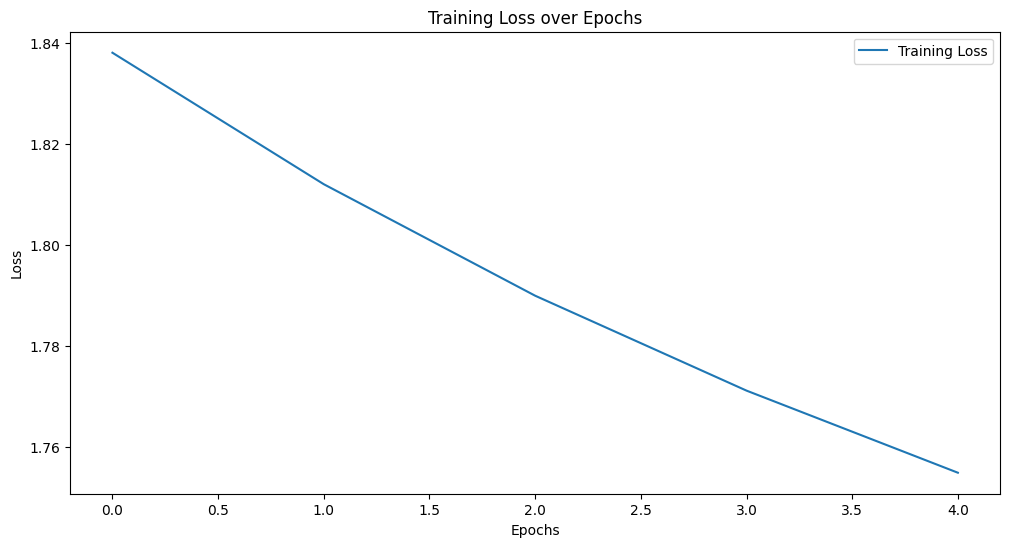

In [60]:
# Print final training loss
final_loss = history.history['loss'][-1]
print(f"Final training loss: {final_loss}")

# Plot training loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [50]:
# Generation
def generate(seed, char_count, temperature=1.0):
    generated = ""
    seed = seed 
    seed_idx = [mapping[char] for char in seed]# Convert the seed text into a list of indices using the mapping dictionary
    generated += seed # Add the seed text to the generated string
    for i in range(char_count):
        seed_idx = [mapping[char] for char in seed]# Convert the seed text into a list of indices using the mapping dictionary
        x_pred = np.reshape(seed_idx, (1, len(seed_idx), 1)) / len_symb # Reshape the seed indices into the input shape expected by the model and normalize them
        prediction = model.predict(x_pred, verbose=0)[0]# Use the model to predict the next character based on the current seed indices
        prediction = np.asarray(prediction).astype('float64')
        prediction = np.log(prediction) / temperature
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        probas = np.random.multinomial(1, prediction, 1)
        index = np.argmax(probas)
        next_char = reverse_mapping[index]
        generated += next_char
        seed = seed[1:] + next_char
    return generated

In [59]:
# Example generation
song = generate("i try to regain some sanity, well it's hard when i lack the composure and no sort of vanity", 100, 0.5)
print(song)

i try to regain some sanity, well it's hard when i lack the composure and no sort of vanity, and a lilh th the beat shat, and love if you went the same thmng that you go sy ma naee, i'm no mo
